# Logistic Regression

## The model

The affairs dataset that comes with Statsmodels. It was derived from a survey of women in 1974 by Redbook magazine, in which married women were asked about their participation in extramarital affairs. More information about the study is available in a 1978 paper from the Journal of Political Economy.



## Desctiption of Variables

The dataset contains 6366 observations of 9 variables:

- rate_marriage: woman's rating of her marriage (1 = very poor, 5 = very good)
- age: woman's age
- yrs_married: number of years married
- children: number of children
- religious: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)
- educ: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)
- occupation: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)
- occupation_husb: husband's occupation (same coding as above)
- affairs: time spent in extra-marital affairs

## Problem statement

I decided to treat this as a classification problem by creating a new binary variable affair (did the woman have at least one affair?) and trying to predict the classification for each woman.

## Import modules

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

## Data Pre-Processing

In [5]:
# load dataset
data = sm.datasets.fair.load_pandas().data

# add "affair" column
data['affair'] = (data.affairs > 0).astype(int)

data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3,32,9.0,3,3,17,2,5,0.111111,1
1,3,27,13.0,3,1,14,3,4,3.230769,1
2,4,22,2.5,0,1,16,3,5,1.400000,1
3,4,37,16.5,4,3,16,5,5,0.727273,1
4,5,27,9.0,1,1,14,3,4,4.666666,1


## Data Exploration

In [7]:
data.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


We can see that on average, women who have affairs rate their marriages lower, which is to be expected. Let's take another look at the rate_marriage variable.

In [8]:
data.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


An increase in age, yrs_married, and children appears to correlate with a declining marriage rating.

## Data Visualization

In [10]:
# show plots in the notebook
%matplotlib inline

### Istograms of education and marriage rating.

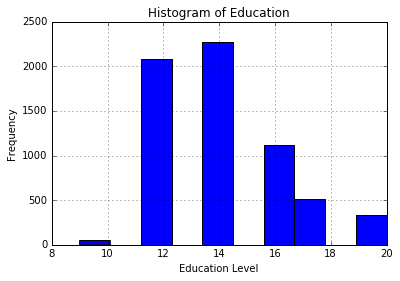

In [13]:
# histogram of education
data.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

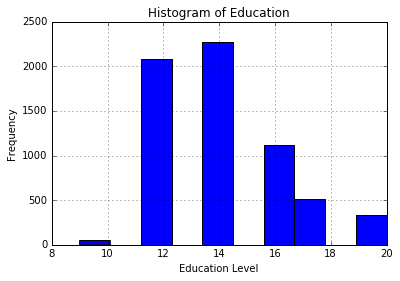

In [14]:
# histogram of education
data.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

Let's take a look at the distribution of marriage ratings for those having affairs versus those not having affairs.

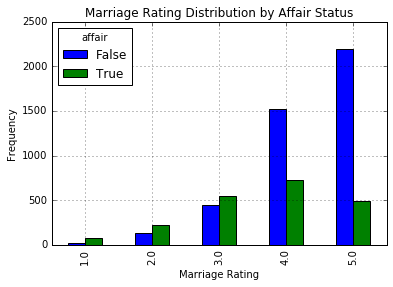

In [46]:
# barplot of marriage rating grouped by affair (True or False)
pd.crosstab(data.rate_marriage, data.affair.astype(bool)).plot(kind='bar')
plt.grid()
plt.title('Marriage Rating Distribution by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Let's use a stacked barplot to look at the percentage of women having affairs by number of years of marriage.

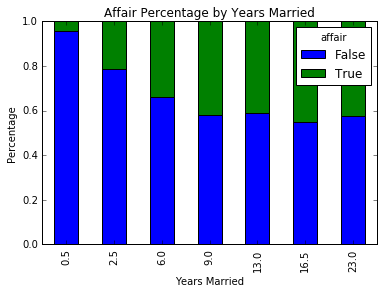

In [19]:
affair_yrs_married = pd.crosstab(data.yrs_married, data.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')

## Prepare Data for Logistic Regression

In [24]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
                  religious + educ + C(occupation) + C(occupation_husb)',
                  data, return_type="dataframe")
print(X.columns)

Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')


In [26]:
# fix column names of X
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

In [27]:
X.head()

,Intercept,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
0,1,1,0,0,0,0,0,0,0,1,0,3,32,9.0,3,3,17
1,1,0,1,0,0,0,0,0,1,0,0,3,27,13.0,3,1,14
2,1,0,1,0,0,0,0,0,0,1,0,4,22,2.5,0,1,16
3,1,0,0,0,1,0,0,0,0,1,0,4,37,16.5,4,3,16
4,1,0,1,0,0,0,0,0,1,0,0,5,27,9.0,1,1,14


In [28]:
# flatten y into a 1-D array
y = np.ravel(y)

## Logistic Regression

In [29]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.72588752748978946

73% accuracy seems good, but what's the null error rate?

In [30]:
# what percentage had affairs?
y.mean()

0.32249450204209867

Only 32% of the women had affairs, which means that you could obtain 68% accuracy by always predicting "no". So we're doing better than the null error rate, but not by much.

## Cross Validation

In [31]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print(predicted)

[ 1.  0.  0. ...,  0.  0.  0.]


In [34]:
# generate class probabilities
probs = model2.predict_proba(X_test)
print(probs)

[[ 0.3514255   0.6485745 ]
 [ 0.9095254   0.0904746 ]
 [ 0.72576645  0.27423355]
 ..., 
 [ 0.55736907  0.44263093]
 [ 0.81213878  0.18786122]
 [ 0.74729574  0.25270426]]


In [36]:
# generate evaluation metrics
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.729842931937
0.74596198609


The accuracy is 73%, which is the same as we experienced when training and predicting on the same data.

## Model Evaluation Using Cross-Validation

Let's try 10-fold cross-validation, to see if the accuracy holds up more rigorously.

In [38]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[ 0.72100313  0.70219436  0.73824451  0.70597484  0.70597484  0.72955975
  0.7327044   0.70440252  0.75157233  0.75      ]
0.724163068551


Looks good. It's still performing at 73% accuracy.

## Predicting the Probability of an Affair

Just for fun, let's predict the probability of an affair for a random woman not present in the dataset. She's a 25-year-old teacher who graduated college, has been married for 3 years, has 1 child, rates herself as strongly religious, rates her marriage as fair, and her husband is a farmer.

In [44]:
x = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 25, 3, 1, 4,16]).reshape(1, -1)
model.predict_proba(x)

array([[ 0.7747467,  0.2252533]])

The predicted probability of an affair is 23%.